In [17]:
# ===== Cell 1: Mount Google Drive =====
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import numpy as np
import pandas as pd
import re
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(style="whitegrid")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
fake_path = "/content/drive/MyDrive/Dataset/Fake.csv"
true_path = "/content/drive/MyDrive/Dataset/True.csv"

fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

fake_df['label'] = 0   # Fake
true_df['label'] = 1   # Real

df = pd.concat([fake_df, true_df], axis=0)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (44898, 5)


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [21]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


,0
title,0
text,0
subject,0
date,0
label,0


In [22]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [23]:
df['text'] = df['text'].astype(str)
df['clean_text'] = df['text'].apply(clean_text)

df[['text', 'clean_text']].head()

,text,clean_text
0,"21st Century Wire says Ben Stein, reputable pr...",st century wire say ben stein reputable profes...
1,WASHINGTON (Reuters) - U.S. President Donald T...,washington reuters u president donald trump re...
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,reuters puerto rico governor ricardo rossello ...
3,"On Monday, Donald Trump once again embarrassed...",monday donald trump embarrassed country accide...
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",glasgow scotland reuters u presidential candid...


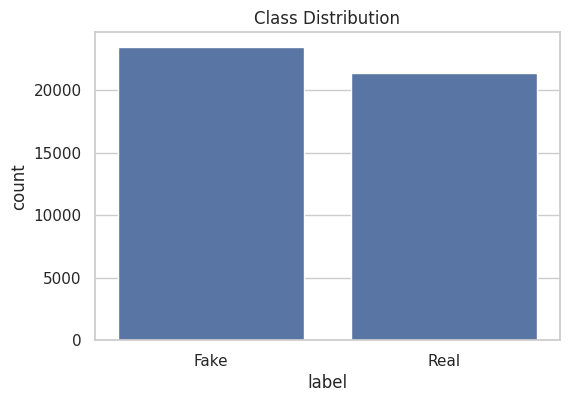

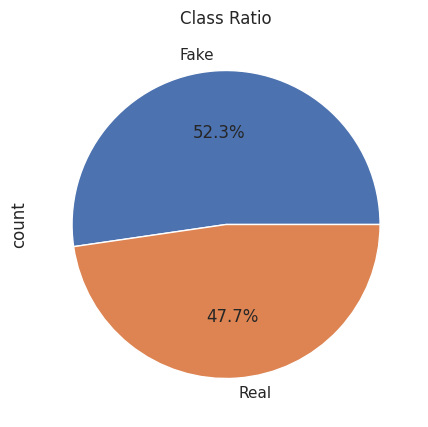

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'])
plt.xticks([0,1], ['Fake','Real'])
plt.title("Class Distribution")
plt.show()

df['label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Fake','Real'],
    figsize=(5,5),
    title="Class Ratio"
)
plt.show()

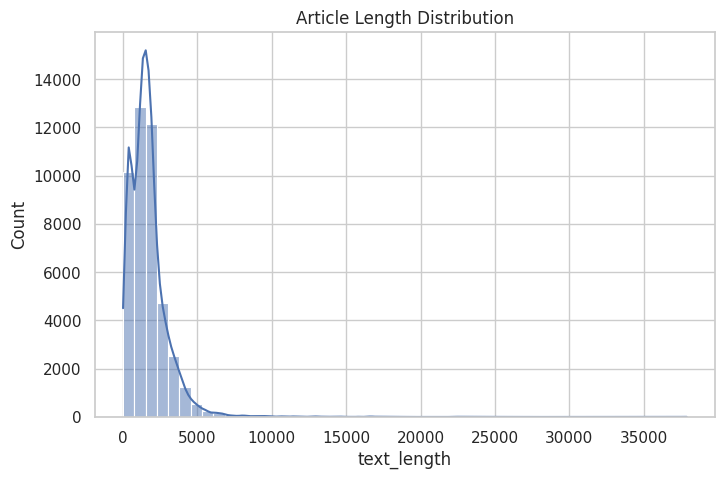

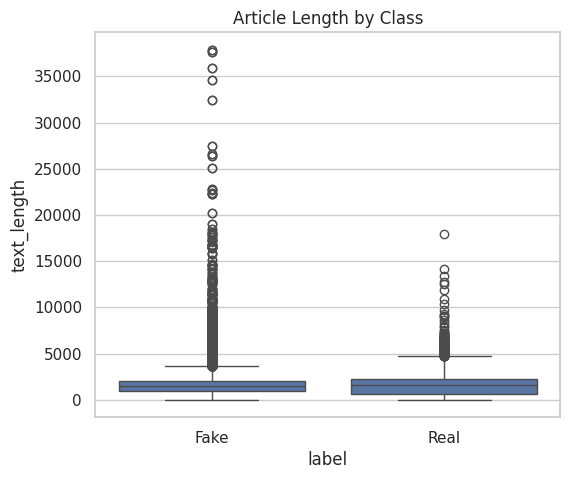

In [25]:
df['text_length'] = df['clean_text'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Article Length Distribution")
plt.show()

plt.figure(figsize=(6,5))
sns.boxplot(x=df['label'], y=df['text_length'])
plt.xticks([0,1], ['Fake','Real'])
plt.title("Article Length by Class")
plt.show()

In [26]:
from collections import Counter

def most_common_words(text_series, n=20):
    all_words = " ".join(text_series).split()
    return Counter(all_words).most_common(n)

before = most_common_words(df['text'])
after = most_common_words(df['clean_text'])

pd.DataFrame(before, columns=['Word','Count'])

,Word,Count
0,the,905825
1,to,529815
2,of,437532
3,and,392470
4,a,390084
5,in,322378
6,that,220928
7,on,181758
8,s,172259
9,for,166256


In [27]:
X = df['clean_text']
y = df['label']

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

In [28]:
fake_keywords = [
    'shocking','breaking','secret','exposed','hoax','fraud',
    'click','conspiracy','scam','fake'
]

def rule_based_predict(text):
    score = sum(word in text for word in fake_keywords)
    return 0 if score > 1 else 1

df['rule_pred'] = df['clean_text'].apply(rule_based_predict)

y_rule = df['rule_pred']

Rule-Based Accuracy: 0.4995768185665286
Rule-Based Precision: 0.4876952256070433
Rule-Based Recall: 0.9724984825138908
Rule-Based F1: 0.649616368286445


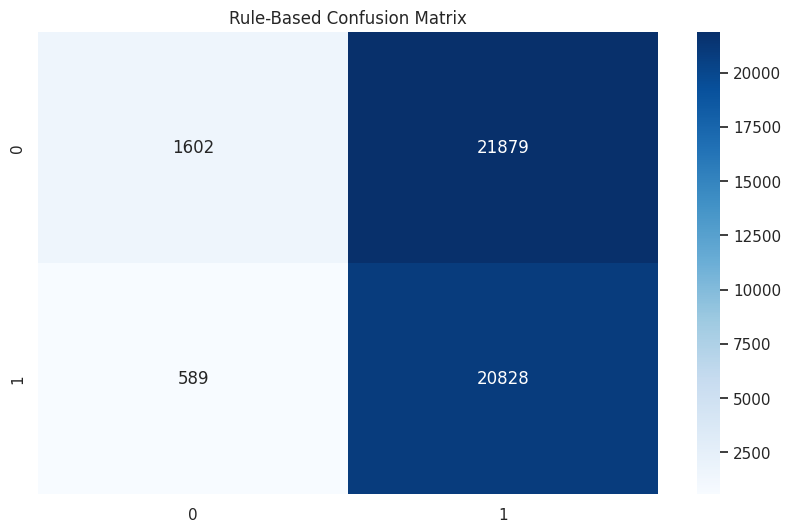

In [29]:
print("Rule-Based Accuracy:", accuracy_score(y, y_rule))
print("Rule-Based Precision:", precision_score(y, y_rule))
print("Rule-Based Recall:", recall_score(y, y_rule))
print("Rule-Based F1:", f1_score(y, y_rule))

cm = confusion_matrix(y, y_rule)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Rule-Based Confusion Matrix")
plt.show()

In [30]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)

In [31]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [32]:
svm = LinearSVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

In [34]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f"{name} Confusion Matrix")
    plt.show()


Naive Bayes
Accuracy: 0.9265033407572383
Precision: 0.9263108171941427
Recall: 0.9185011709601874
F1: 0.9223894637817498


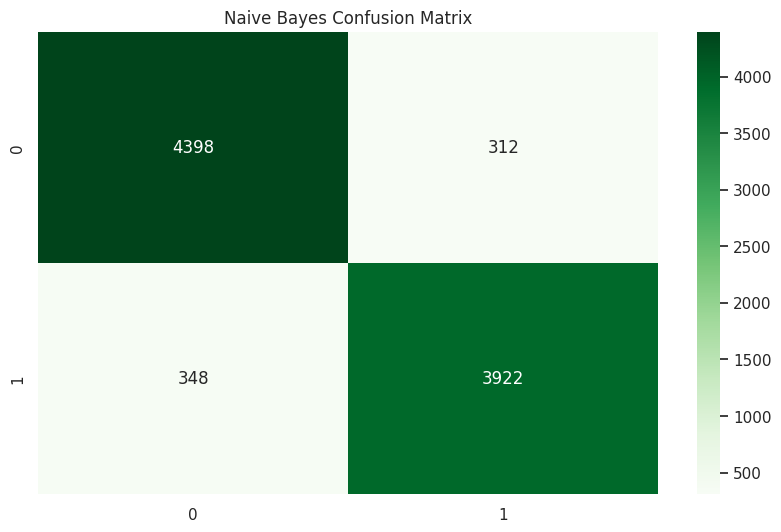


Logistic Regression
Accuracy: 0.9837416481069042
Precision: 0.9779786740843764
Recall: 0.988056206088993
F1: 0.9829916123019571


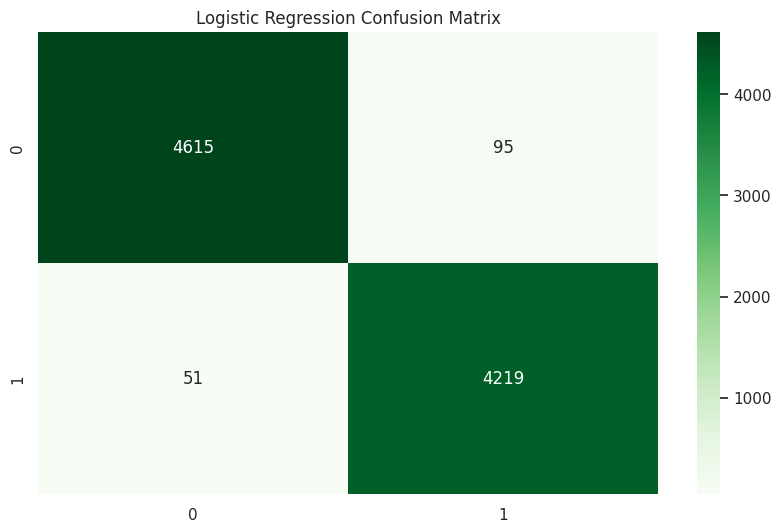


Linear SVM
Accuracy: 0.9924276169265034
Precision: 0.9906585707613265
Recall: 0.9934426229508196
F1: 0.9920486435921422


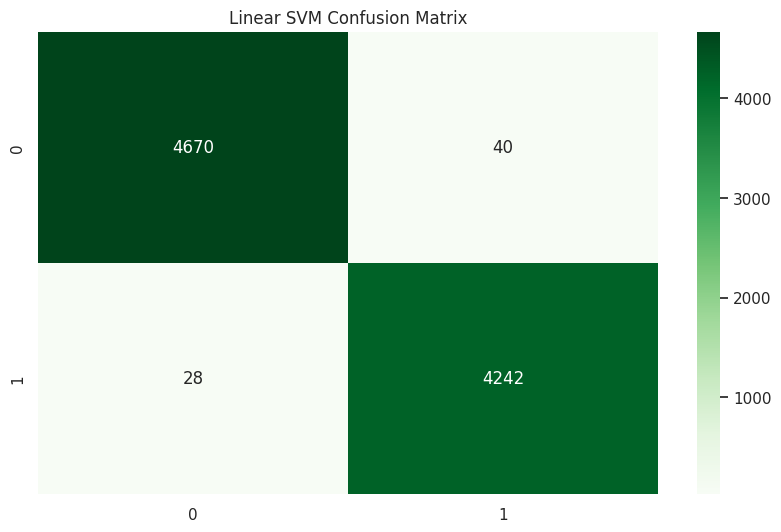

In [35]:
evaluate_model("Naive Bayes", y_test, nb_pred)
evaluate_model("Logistic Regression", y_test, lr_pred)
evaluate_model("Linear SVM", y_test, svm_pred)

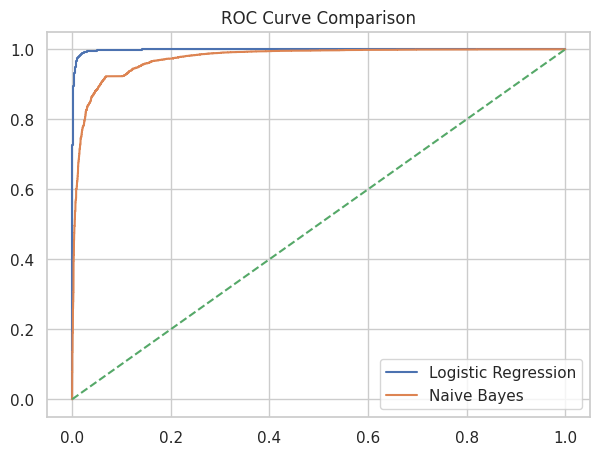

In [36]:
lr_probs = lr.predict_proba(X_test)[:,1]
nb_probs = nb.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_nb, tpr_nb, label="Naive Bayes")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curve Comparison")
plt.show()

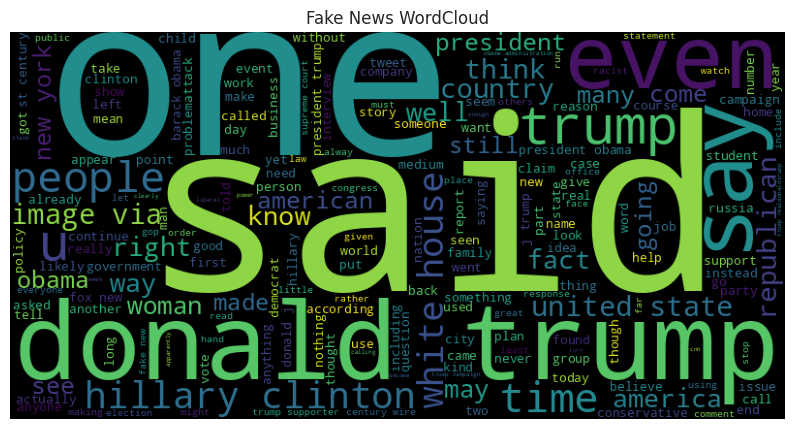

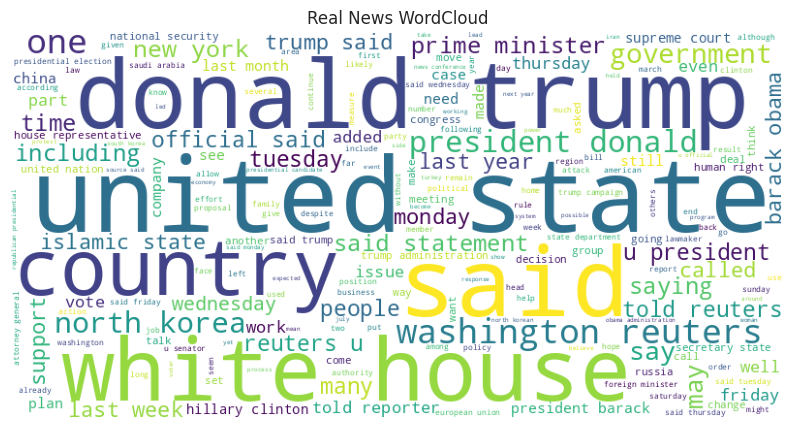

In [37]:
fake_text = " ".join(df[df['label']==0]['clean_text'])
real_text = " ".join(df[df['label']==1]['clean_text'])

WordCloud(width=800,height=400,background_color='black').generate(fake_text)
plt.imshow(WordCloud(width=800,height=400,background_color='black').generate(fake_text))
plt.axis('off')
plt.title("Fake News WordCloud")
plt.show()

plt.imshow(WordCloud(width=800,height=400,background_color='white').generate(real_text))
plt.axis('off')
plt.title("Real News WordCloud")
plt.show()

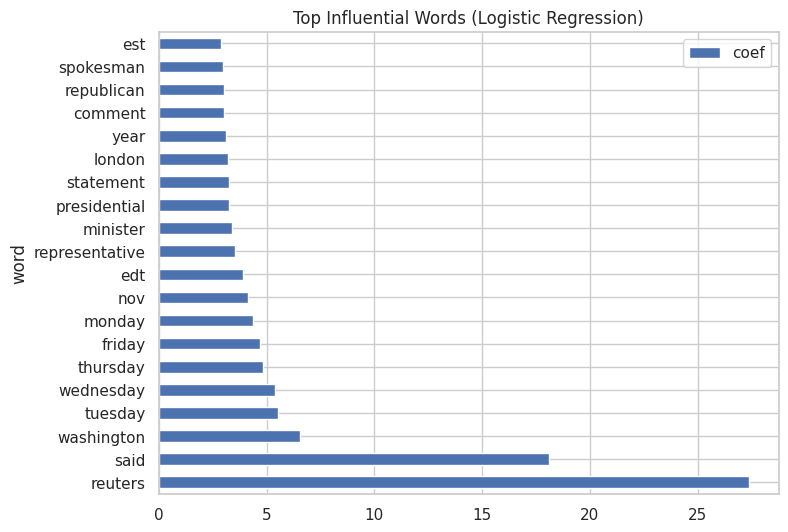

In [38]:
feature_names = tfidf.get_feature_names_out()
coefs = lr.coef_[0]

top_features = pd.DataFrame({
    'word': feature_names,
    'coef': coefs
}).sort_values(by='coef', ascending=False).head(20)

top_features.plot.barh(x='word', y='coef', figsize=(8,6))
plt.title("Top Influential Words (Logistic Regression)")
plt.show()

In [39]:
results = pd.DataFrame({
    'Model': ['Rule-Based','Naive Bayes','Logistic Regression','Linear SVM'],
    'F1 Score': [
        f1_score(y, y_rule),
        f1_score(y_test, nb_pred),
        f1_score(y_test, lr_pred),
        f1_score(y_test, svm_pred)
    ]
})

results

,Model,F1 Score
0,Rule-Based,0.649616
1,Naive Bayes,0.922389
2,Logistic Regression,0.982992
3,Linear SVM,0.992049


In [40]:
best_model = results.sort_values(by='F1 Score', ascending=False).iloc[0]
print("Best Performing Model:", best_model['Model'])
print("Best F1 Score:", best_model['F1 Score'])

Best Performing Model: Linear SVM
Best F1 Score: 0.9920486435921422
